### Input

In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import helpfunction as helper
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import pickle

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [4]:
x_sce_magic = 1.03
pid_upper_clip = 300
pot_target = 1e20
lee_focus = 1

<IPython.core.display.Javascript object>

In [5]:
x_sce_magic = 1.03
pid_upper_clip = 300
pot_target = 1e20

<IPython.core.display.Javascript object>

In [6]:
max_trk_score = 0.4
min_cluster_frac = 0.6

<IPython.core.display.Javascript object>

In [7]:
retrain = True
train_samples = ["train"]
seed = 7
test_size = 0.25

<IPython.core.display.Javascript object>

### Load Samples

In [8]:
run = 1
input_dir = "./input/15Nov/run{}/".format(run)
output_dir = "./output/run{}/".format(run)
model_dir = "./models/run{}/".format(run)

<IPython.core.display.Javascript object>

In [9]:
exclude_samples = []  # ["nu", "train", "on", "off"]
sample_info, fields = helper.load_sample_info(input_dir, run, exclude_samples)
pot_scale = pot_target / sample_info["on"]["pot"]

Sample Summary: [name, POT, Scaling, Events, SliceID passing rate]


ValueError: cannot use flatten=True on branches with different jagged structure, such as electrons and muons (different, variable number of each per event); either explicitly select compatible branches, such as ["MET_*", "Muon_*"] (scalar and variable per event is okay), or set flatten=False

<IPython.core.display.Javascript object>

### Explore Tree

In [10]:
shr_fields = [f for f in fields if f.startswith("shr_") and f.endswith("_v")]
trk_fields = [f for f in fields if f.startswith("trk_") and f.endswith("_v")]
backracked_fields = [f for f in fields if f.startswith("backtracked_")]
mc_fields = [f for f in fields if f.startswith(("true_", "mc_"))]
other_fields = (
    set(fields)
    - set(shr_fields)
    - set(trk_fields)
    - set(backracked_fields)
    - set(mc_fields)
)

<IPython.core.display.Javascript object>

In [11]:
trk_fields

['trk_score_v',
 'trk_bragg_p_v',
 'trk_bragg_mu_v',
 'trk_bragg_mip_v',
 'trk_pida_v',
 'trk_pid_chipr_v',
 'trk_pid_chipi_v',
 'trk_pid_chika_v',
 'trk_pid_chimu_v',
 'trk_bragg_p_u_v',
 'trk_bragg_mu_u_v',
 'trk_bragg_mip_u_v',
 'trk_pida_u_v',
 'trk_pid_chipr_u_v',
 'trk_pid_chipi_u_v',
 'trk_pid_chika_u_v',
 'trk_pid_chimu_u_v',
 'trk_bragg_p_v_v',
 'trk_bragg_mu_v_v',
 'trk_bragg_mip_v_v',
 'trk_pida_v_v',
 'trk_pid_chipr_v_v',
 'trk_pid_chipi_v_v',
 'trk_pid_chika_v_v',
 'trk_pid_chimu_v_v',
 'trk_pfp_id_v',
 'trk_dir_x_v',
 'trk_dir_y_v',
 'trk_dir_z_v',
 'trk_start_x_v',
 'trk_start_y_v',
 'trk_start_z_v',
 'trk_sce_start_x_v',
 'trk_sce_start_y_v',
 'trk_sce_start_z_v',
 'trk_end_x_v',
 'trk_end_y_v',
 'trk_end_z_v',
 'trk_sce_end_x_v',
 'trk_sce_end_y_v',
 'trk_sce_end_z_v',
 'trk_distance_v',
 'trk_theta_v',
 'trk_phi_v',
 'trk_len_v',
 'trk_mcs_muon_mom_v',
 'trk_energy_proton_v',
 'trk_energy_muon_v',
 'trk_calo_energy_u_v',
 'trk_calo_energy_v_v',
 'trk_calo_energy_y_v',

<IPython.core.display.Javascript object>

In [12]:
shr_fields

['shr_dedx_u_v',
 'shr_dedx_v_v',
 'shr_dedx_y_v',
 'shr_energy_u_v',
 'shr_energy_v_v',
 'shr_energy_y_v',
 'shr_pfp_id_v',
 'shr_start_x_v',
 'shr_start_y_v',
 'shr_start_z_v',
 'shr_start_U_v',
 'shr_start_V_v',
 'shr_dist_v',
 'shr_nclus0_v',
 'shr_clushitfrac0_v',
 'shr_nclus1_v',
 'shr_clushitfrac1_v',
 'shr_nclus2_v',
 'shr_clushitfrac2_v',
 'shr_px_v',
 'shr_py_v',
 'shr_pz_v',
 'shr_openangle_v',
 'shr_theta_v',
 'shr_phi_v',
 'shr_pitch_u_v',
 'shr_pitch_v_v',
 'shr_pitch_y_v',
 'shr_tkfit_nhits_v',
 'shr_tkfit_start_x_v',
 'shr_tkfit_start_y_v',
 'shr_tkfit_start_z_v',
 'shr_tkfit_start_U_v',
 'shr_tkfit_start_V_v',
 'shr_tkfit_theta_v',
 'shr_tkfit_phi_v',
 'shr_tkfit_pitch_u_v',
 'shr_tkfit_pitch_v_v',
 'shr_tkfit_pitch_y_v',
 'shr_tkfit_dedx_u_v',
 'shr_tkfit_dedx_v_v',
 'shr_tkfit_dedx_y_v',
 'shr_tkfit_gap10_dedx_u_v',
 'shr_tkfit_gap10_dedx_v_v',
 'shr_tkfit_gap10_dedx_y_v',
 'shr_tkfit_dedx_nhits_u_v',
 'shr_tkfit_dedx_nhits_v_v',
 'shr_tkfit_dedx_nhits_y_v',
 'shr_mo

<IPython.core.display.Javascript object>

In [13]:
backracked_fields

['backtracked_pdg',
 'backtracked_e',
 'backtracked_purity',
 'backtracked_completeness',
 'backtracked_overlay_purity',
 'backtracked_px',
 'backtracked_py',
 'backtracked_pz',
 'backtracked_start_x',
 'backtracked_start_y',
 'backtracked_start_z',
 'backtracked_start_t',
 'backtracked_start_U',
 'backtracked_start_V',
 'backtracked_start_Y',
 'backtracked_sce_start_x',
 'backtracked_sce_start_y',
 'backtracked_sce_start_z',
 'backtracked_sce_start_U',
 'backtracked_sce_start_V',
 'backtracked_sce_start_Y']

<IPython.core.display.Javascript object>

In [14]:
other_fields

{'CosmicDirAll2DEnds',
 'CosmicDirAll2DOvlp',
 'CosmicDirAll3D',
 'CosmicIP',
 'CosmicIPAll2DEnds',
 'CosmicIPAll2DOvlp',
 'CosmicIPAll3D',
 'NeutrinoEnergy0',
 'NeutrinoEnergy1',
 'NeutrinoEnergy2',
 'SliceCaloEnergy0',
 'SliceCaloEnergy1',
 'SliceCaloEnergy2',
 'bdt_cosmic',
 'bdt_ext',
 'bdt_global',
 'bdt_nuNCpi0',
 'bdt_numuCC',
 'bdt_numuCCpi0',
 'best_cosmic_flashmatch_score',
 'best_obviouscosmic_flashmatch_score',
 'category',
 'ccnc',
 'contained_fraction',
 'contained_sps_ratio',
 'cosmic_flashmatch_score_v',
 'crthitpe',
 'crtveto',
 'dmc_boundary',
 'dshr_boundary',
 'dshr_x_boundary',
 'dshr_y_boundary',
 'dshr_z_boundary',
 'dtrk',
 'dtrk_boundary',
 'dtrk_x_boundary',
 'dtrk_y_boundary',
 'dtrk_z_boundary',
 'dvtx',
 'dvtx_boundary',
 'dvtx_x_boundary',
 'dvtx_y_boundary',
 'dvtx_z_boundary',
 'elec_c',
 'elec_dist',
 'elec_e',
 'elec_edep',
 'elec_etot',
 'elec_p',
 'elec_parent',
 'elec_vx',
 'elec_vy',
 'elec_vz',
 'endmuonmichel',
 'endmuonprocess',
 'evgamnhits',
 

<IPython.core.display.Javascript object>

In [15]:
# search through fields:
[f for f in fields if "_vk" in f]

[]

<IPython.core.display.Javascript object>

### Add fields

In [16]:
sample_info["on"]["daughters"].keys()

Index(['run', 'sub', 'evt', 'topological_score', 'n_pfps', 'n_showers',
       'n_tracks', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y',
       'reco_nu_vtx_sce_z', 'reco_nu_vtx_x', 'reco_nu_vtx_y', 'reco_nu_vtx_z',
       'crtveto', 'crthitpe', 'slclustfrac', 'hits_ratio',
       'nu_flashmatch_score', 'selected', 'category', 'nslice', 'CosmicIP',
       'n_tracks_contained', 'contained_sps_ratio', 'contained_fraction',
       'slpdg', 'trk_score_v', 'trk_distance_v', 'trk_theta_v', 'trk_phi_v',
       'trk_len_v', 'trk_pid_chipr_v', 'trk_pid_chimu_v', 'trk_pid_chipr_v_v',
       'trk_pid_chimu_v_v', 'trk_pid_chipr_u_v', 'trk_pid_chimu_u_v',
       'trk_llr_pid_u_v', 'trk_llr_pid_v_v', 'trk_llr_pid_y_v',
       'trk_llr_pid_v', 'trk_llr_pid_score_v', 'trk_mcs_muon_mom_v',
       'trk_calo_energy_y_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v',
       'trk_sce_end_z_v', 'shr_dist_v', 'shr_energy_y_v', 'shr_openangle_v',
       'shr_tkfit_start_x_v', 'shr_tkfit_start_y_v', 'shr_tkfit_start_z_v',

<IPython.core.display.Javascript object>

In [17]:
%%time
# For all samples
for k, v in sample_info.items():
    print(k)
    # Add fiducial reco sce vtx
    v["daughters"]["reco_fid_vol"] = np.repeat(
        helper.is_fid(
            *v["daughters"][
                ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
            ]
            .xs(0, level="daughter")
            .values.T
        ),
        v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )
    # Add pfp at vtx:
    v["daughters"]["n_pfpvtx"] = v["daughters"].eval("trk_distance_v<3 & trk_distance_v>=0")
    v["daughters"]["n_pfpvtx"] = v["daughters"]['n_pfpvtx'].groupby("event").transform(sum)
    v["daughters"]["n_pfp_farvtx"] = v["daughters"].eval("n_pfps-n_pfpvtx")
    
    # Add electron candidate check
    e_cand_str = 'pfnplanehits_U>0 & pfnplanehits_V>0 & pfnplanehits_Y>0 & trk_score_v<@max_trk_score & shr_tkfit_dedx_nhits_y_v>0 & pfp_generation_v==2'    
    data = v["daughters"][
                [
                    "pfnplanehits_U", "pfnplanehits_V", "pfnplanehits_Y",
                    "trk_score_v",'shr_tkfit_dedx_nhits_y_v',
                    "shr_dist_v", 'pfp_generation_v', "shr_energy_y_v"
                ]
            ]
    electron_candidate = data.eval(e_cand_str)
    e_cand_maxe = data[electron_candidate]["shr_energy_y_v"].groupby("event").transform(max) == data[electron_candidate]["shr_energy_y_v"]
    v["daughters"]["e_candidate"] = False
    v["daughters"].loc[e_cand_maxe[e_cand_maxe == True].index, "e_candidate"] = True
    # Add weighted dedx:
    dedx_cols = ["shr_tkfit_dedx_u_v",
                    "shr_tkfit_dedx_v_v",
                    "shr_tkfit_dedx_y_v",
                    'shr_tkfit_nhits_v',
                    "shr_tkfit_dedx_nhits_u_v",
                    "shr_tkfit_dedx_nhits_v_v",
                    "shr_tkfit_dedx_nhits_y_v"]
    v["daughters"][dedx_cols]=v["daughters"][dedx_cols].clip(lower=0)
    str_dedx_weighted_mean='(shr_tkfit_dedx_u_v*shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_v_v*shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_y_v*shr_tkfit_dedx_nhits_y_v)/(shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_nhits_y_v)'
    v["daughters"]['shr_tkfit_dedx_wm_v']= v["daughters"].eval(str_dedx_weighted_mean)
    # Add weigthed pid chi mu/pr:
    pid_chi_cols = ["trk_pid_chipr_v",
    "trk_pid_chimu_v",
    "trk_pid_chipr_v_v",
    "trk_pid_chimu_v_v",
    "trk_pid_chipr_u_v",
    "trk_pid_chimu_u_v"]
    v["daughters"][pid_chi_cols]=v["daughters"][pid_chi_cols].clip(upper=pid_upper_clip)
    str_pidmu_weighted_mean='(trk_pid_chimu_v*pfnplanehits_Y+trk_pid_chimu_v_v*pfnplanehits_V+trk_pid_chimu_u_v*pfnplanehits_U)/pfnhits'
    v["daughters"]['trk_pid_chimu_wm_v']= v["daughters"].eval(str_pidmu_weighted_mean)
    str_pidpr_weighted_mean='(trk_pid_chipr_v*pfnplanehits_Y+trk_pid_chipr_v_v*pfnplanehits_V+trk_pid_chipr_u_v*pfnplanehits_U)/pfnhits'
    v["daughters"]['trk_pid_chipr_wm_v']= v["daughters"].eval(str_pidpr_weighted_mean)
    # Add the number of hits per length:
    v["daughters"]['hits_per_tklen']= v["daughters"].eval('pfnhits/trk_len_v')
    # Add the ratio between dedx at 0cm and 1cm:
    v["daughters"]['shr_tkfit_ratiogap_dedx_y_v']= v["daughters"].eval('shr_tkfit_dedx_y_v/shr_tkfit_gap10_dedx_y_v')
    # Explore mcs muon momentum:
    v["daughters"]['trk_muon_hypothesis_ratio_v']= v["daughters"].eval('trk_mcs_muon_mom_v/trk_calo_energy_y_v')
    
    
    # Drop columns I do not need anymore:
    drop_cols = [
    "pfnplanehits_U",
    "pfnplanehits_V",
    "pfnplanehits_Y",
    'pfnhits',
    "shr_tkfit_dedx_u_v",
    "shr_tkfit_dedx_v_v",
    "shr_tkfit_nhits_v",
    "shr_tkfit_dedx_nhits_u_v",
    "shr_tkfit_dedx_nhits_v_v",    
    "trk_pid_chipr_v_v",
    "trk_pid_chimu_v_v",
    "trk_pid_chipr_u_v",
    "trk_pid_chimu_u_v",
]
for c in drop_cols:
    if c in v["daughters"].columns:
        v["daughters"].drop(c, inplace=True, axis=1)
    else:
        print(c, " was not in dataframe!")

on
off
dirt
train
nu
nue
CPU times: user 7.05 s, sys: 1.46 s, total: 8.51 s
Wall time: 5.21 s


<IPython.core.display.Javascript object>

In [18]:
%%time
# For MC samples
for k, v in sample_info.items():
    if k not in helper.data_samples:
        
        # Correct the LEE weight using the splineweight
        v['daughters']["leeweight"]*=v['daughters']["weightSpline"]
        
        # Add distance between reco_sce and true vertex
        data = (
            v["daughters"][
                [
                    "reco_nu_vtx_sce_x",
                    "reco_nu_vtx_sce_y",
                    "reco_nu_vtx_sce_z",
                    "true_nu_vtx_x",
                    "true_nu_vtx_y",
                    "true_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        data[0]-=x_sce_magic # Correct x location for the 0.6 sign error
        
        v["daughters"]["true_vtx_distance"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Cross-check vtx distance
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "reco_nu_vtx_x",
                    "reco_nu_vtx_y",
                    "reco_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        v["daughters"]["true_vtx_distance_check"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Add the distance between the true neutrino vertex and the reconstructed shower start point
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "shr_tkfit_start_x_v",
                    "shr_tkfit_start_y_v",
                    "shr_tkfit_start_z_v",
                ]
            ]
            .values.T
        )
        v["daughters"]["true_shower_distance"] = np.linalg.norm(data[0:3] - data[3:6], axis=0)
        
        # Add the modified purity/completeness to account for overlay.
        overlay_mask = v["daughters"].eval('backtracked_overlay_purity>backtracked_purity')
        v["daughters"].loc[overlay_mask, 'backtracked_pdg'] = 0
        v["daughters"].loc[overlay_mask, 'backtracked_purity'] = v["daughters"].loc[overlay_mask, 'backtracked_overlay_purity']
        v["daughters"].loc[overlay_mask, 'backtracked_completeness'] = 0
        
        # Drop some stuff you do not need anymore
        drop_cols = ['backtracked_overlay_purity',
                     "true_nu_vtx_sce_y",
                     "true_nu_vtx_sce_z",
                     "reco_nu_vtx_y",
                     "reco_nu_vtx_z"]
        for c in drop_cols:
            if c in v["daughters"].columns:
                v["daughters"].drop(c, inplace=True, axis=1)
            else:
                print(c, " was not in dataframe!")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/numpy/linalg/linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


CPU times: user 5.83 s, sys: 2.27 s, total: 8.1 s
Wall time: 4.35 s


<IPython.core.display.Javascript object>

In [19]:
%%time
# For MC samples, fields needed as training labels:
for k, v in sample_info.items():
    if k not in helper.data_samples:
        # Add training labels and weights
        e_cand = v["daughters"]['e_candidate']
        e_good = v["daughters"].eval('e_candidate & abs(backtracked_pdg)==11 & backtracked_purity>0.75 & backtracked_completeness>0.5')
        e_cand_bad = v["daughters"].eval('e_candidate & abs(backtracked_pdg)!=11')
        other_bad = v["daughters"].eval('~e_candidate & (abs(backtracked_pdg)==13 | backtracked_pdg==22 | backtracked_pdg==0)') #| abs(backtracked_pdg)==211)')
        
        v["daughters"]['train_weight'] = v["daughters"].eval('weightSpline+leeweight*@lee_focus') # weight low energy electrons a bit higher
        v["daughters"]['train_weight'] = v["daughters"].eval('train_weight*(1+(150<shr_energy_y_v<400)*@lee_focus)') # weight low energy electrons a bit higher
        
        v["daughters"].loc[e_good, "train_weight"] *= 5 # can be tuned
        
        v["daughters"]['train_label'] = True
        v["daughters"].loc[e_cand_bad, "train_label"] = False
        v["daughters"].loc[other_bad, "train_label"] = False

CPU times: user 1.67 s, sys: 18.7 ms, total: 1.69 s
Wall time: 881 ms


<IPython.core.display.Javascript object>

In [20]:
# In case we train on external data:
# sample_info["Off"]["daughters"]["nueccinc"] = False
# sample_info["Off"]["daughters"]["train_weight"] = 1
# low_e_shr = sample_info["Off"]["daughters"].eval("shr_energy_y_v<0.4")
# sample_info["Off"]["daughters"].loc[low_e_shr, "train_weight"] *= 5  # can be tuned
# sample_info["Off"]["daughters"]["train_label"] = False

<IPython.core.display.Javascript object>

### Quality cuts / Pre-selection

In [21]:
query_preselect = "e_candidate & reco_fid_vol & slclustfrac>@min_cluster_frac & ~crtveto & _closestNuCosmicDist>20 & shr_energy_y_v>50"

<IPython.core.display.Javascript object>

In [22]:
%%time
# Passing rate pre-selection
for k, v in sample_info.items():
    # If no CRT info is there, add the field for continuity.
    if "_closestNuCosmicDist" not in v["daughters"]:
        v["daughters"]["_closestNuCosmicDist"]=999
    v["daughters"]["preselect"] = v["daughters"].eval(
        query_preselect
    )
    v["daughters"]["preselect"] = v["daughters"]["preselect"].groupby("event").transform(max)
    
    pass_rate = sum(v["daughters"].eval("e_candidate & preselect"))/v['numentries']
    print(k, "\t{:.2f}%".format(pass_rate * 100))
    
# Passing rate signal, weights applied!
pass_rate = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*weightSpline*nueccinc'))/sum(sample_info["nue"]["mc"]['weightSpline']*sample_info['nue']['mc']['nueccinc'] )
print("Nue signal passing the preselection \t{:.2f}%".format(pass_rate * 100))
nue_pass = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*nueccinc'))*sample_info["nue"]['scaling']*pot_scale
print("Nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(nue_pass,pot_target))
lee_pass = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*leeweight*nueccinc'))*sample_info["nue"]['scaling']*pot_scale
print("Nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass,pot_target))

## Calculate the purity:
purity_denom = (
    sum(sample_info["nu"]["daughters"].eval("(e_candidate & preselect)*weightSpline"))
    * sample_info["nu"]["scaling"]
)
purity_denom += (
    sum(sample_info["dirt"]["daughters"].eval("(e_candidate & preselect)*weightSpline"))
    * sample_info["dirt"]["scaling"]
)
purity_denom += (
    sum(sample_info["off"]["daughters"].eval("(e_candidate & preselect)")) * sample_info["off"]["scaling"]
)

purity_mc = (
    sum(sample_info["nue"]["daughters"].eval("(e_candidate & preselect)*weightSpline*nueccinc"))
    * sample_info["nue"]["scaling"]
    / purity_denom
)
purity_data = (
    sum(sample_info["nue"]["daughters"].eval("(e_candidate & preselect)*weightSpline*nueccinc"))
    * sample_info["nue"]["scaling"]
    / sum(sample_info["on"]["daughters"].eval("(e_candidate & preselect)"))
)
print(
    "Purity MC: {:.1f}%\nData/MC-ratio: {:.2f}\n".format(
        purity_mc * 100,
        sum(sample_info["on"]["daughters"].eval("(e_candidate & preselect)")) / purity_denom,
    )
)

on 	0.84%
off 	0.31%
dirt 	0.20%
train 	10.04%
nu 	3.16%
nue 	41.42%
Nue signal passing the preselection 	47.64%
Nue Intrinsic signal passing: 68.940 per 1e+20 POT
Nue LEE signal passing: 4.073 per 1e+20 POT


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Purity MC: 2.0%
Data/MC-ratio: 0.93

CPU times: user 1.77 s, sys: 15.7 ms, total: 1.78 s
Wall time: 942 ms


<IPython.core.display.Javascript object>

### Machine Learning Selection

In [23]:
col_train_electron = [
    "trk_score_v",
    # "trk_len_v",
    # "trk_pid_chipr_v",
    # "trk_pid_chimu_v",
    "trk_llr_pid_score_v",
    "trk_min_cos",
    # "hits_per_tklen",
    "shr_dist_v",
    "shr_energy_y_v",
    # "shr_openangle_v",
    # "shr_tkfit_theta_v",
    # "shr_tkfit_phi_v",
    "shr_tkfit_dedx_wm_v",
    "shr_tkfit_dedx_y_v",
    # "shr_tkfit_gap10_dedx_y_v",
    "shr_moliere_avg_v",
    # "shr_clushitfrac2_v",
    # "shr_tkfit_dedx_nhits_y_v",
    ##"train_weight",
    ##"train_label",
]
col_train_other = [
    # "topological_score",
    # "n_showers",
    # "n_tracks",
    # "n_pfpvtx",
    "trk_score_v",
    "trk_distance_v",
    # "trk_theta_v",
    # "trk_phi_v",
    "trk_len_v",
    "trk_llr_pid_score_v",
    "trk_llr_pid_y_v",
    # "trk_pid_chimu_wm_v",
    # "trk_pid_chipr_wm_v",
    # "trk_min_cos",
    "trk_muon_hypothesis_ratio_v",
    # "hits_per_tklen",
    # "shr_energy_y_v",
    # "shr_openangle_v",
    "shr_tkfit_dedx_wm_v",
    "pfp_generation_v"
    ##"train_weight",
    ##"train_label",
]

col_train_event = [
    "topological_score",
    "n_showers",
    # "n_tracks",
    # "n_pfpvtx",
    "n_pfp_farvtx",
    "hits_ratio",
    # "contained_sps_ratio",
    "contained_fraction",
    "score",
    # "score_other_max",
    "score_other_min",
    "score_other_mean",
    "CosmicIP"
    ## nueccinc
    ## train_weight -> use the train weight of the electron candidate
]

<IPython.core.display.Javascript object>

#### Electron training

In [24]:
train_q = "preselect & e_candidate"

X_train = []
X_test = []
y_train = []
y_test = []
for k in train_samples:
    X = sample_info[k]["daughters"].query(train_q)[col_train_electron]
    Y = sample_info[k]["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [25]:
# fit model no training data
if retrain:
    model_e = XGBClassifier(max_depth=5)
    model_e.fit(X_train, y_train["train_label"], sample_weight=y_train["train_weight"])
    dump(model_e, model_dir + "model_e.pckl")
else:
    model_e = load(model_dir + "model_e.pckl")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


<IPython.core.display.Javascript object>

In [26]:
# make predictions for test data
y_pred = model_e.predict(X_test)
target_names = ["electron", "non_electron"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_e.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_e.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_electron)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

              precision    recall  f1-score   support

    electron       0.91      0.40      0.56     12228
non_electron       0.66      0.97      0.79     14932

    accuracy                           0.71     27160
   macro avg       0.79      0.68      0.67     27160
weighted avg       0.78      0.71      0.68     27160

Test accuracy: 71.23%
Train accuracy: 71.51%

1. feature shr_dist_v (0.421918)
2. feature shr_tkfit_dedx_wm_v (0.118772)
3. feature shr_energy_y_v (0.109126)
4. feature shr_moliere_avg_v (0.093023)
5. feature shr_tkfit_dedx_y_v (0.083804)
6. feature trk_min_cos (0.074353)
7. feature trk_llr_pid_score_v (0.066205)
8. feature trk_score_v (0.032799)


<IPython.core.display.Javascript object>

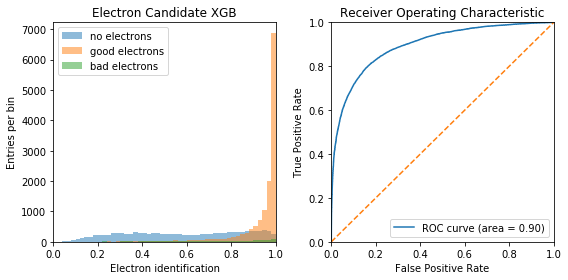

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_e.predict_proba(X_test).T[1]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="no electrons",
    density=False,
)
ax[0].hist(
    y_pred[(y_test["train_label"] == 1) & (y_test["train_weight"] > 2)],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="good electrons",
    density=False,
)
ax[0].hist(
    y_pred[(y_test["train_label"] == 1) & (y_test["train_weight"] < 2)],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="bad electrons",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Electron identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Electron Candidate XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "e_bdt_test.pdf")

#### Other daughters training

In [28]:
train_q = "preselect & ~e_candidate"
X_train = []
X_test = []
y_train = []
y_test = []
for k in train_samples:
    X = sample_info[k]["daughters"].query(train_q)[col_train_other]
    Y = sample_info[k]["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [29]:
# fit model on training data
if retrain:
    model_d = XGBClassifier(max_depth=6)
    model_d.fit(X_train, y_train["train_label"], sample_weight=y_train["train_weight"])
    dump(model_d, model_dir + "model_d.pckl")
else:
    model_d = load(model_dir + "model_d.pckl")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


<IPython.core.display.Javascript object>

In [30]:
# make predictions for test data
y_pred = model_d.predict(X_test)
target_names = ["proton, pion, ...", "muon, overlay, photon"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_d.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_d.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_other)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                       precision    recall  f1-score   support

    proton, pion, ...       0.80      0.69      0.74     34116
muon, overlay, photon       0.74      0.84      0.78     35634

             accuracy                           0.76     69750
            macro avg       0.77      0.76      0.76     69750
         weighted avg       0.77      0.76      0.76     69750

Test accuracy: 76.48%
Train accuracy: 76.84%

1. feature trk_llr_pid_score_v (0.385360)
2. feature trk_distance_v (0.335779)
3. feature trk_score_v (0.078231)
4. feature trk_len_v (0.061864)
5. feature trk_llr_pid_y_v (0.061602)
6. feature pfp_generation_v (0.030385)
7. feature trk_muon_hypothesis_ratio_v (0.023453)
8. feature shr_tkfit_dedx_wm_v (0.023324)


<IPython.core.display.Javascript object>

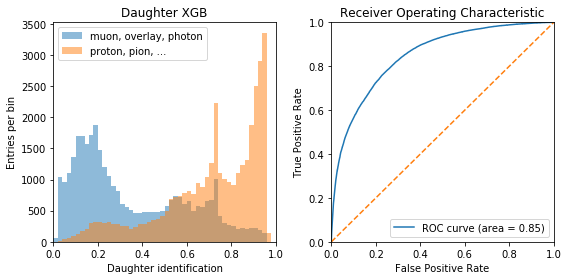

<IPython.core.display.Javascript object>

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_d.predict_proba(X_test).T[1]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="muon, overlay, photon",
    density=False,
)
ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="proton, pion, ...",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Daughter identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Daughter XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "daughter_bdt_test.pdf")

#### Apply models on the samples!

In [32]:
%time
# add the columns for each daughter (all samples)
for k, v in sample_info.items():
    v["daughters"]["score"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score"] = model_e.predict_proba(
        v["daughters"][col_train_electron][mask_e_cand]
    ).T[1]
    mask_d = v["daughters"].eval("preselect & ~e_candidate")
    v["daughters"].loc[mask_d, "score"] = model_d.predict_proba(
        v["daughters"][col_train_other][mask_d]
    ).T[1]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


<IPython.core.display.Javascript object>

#### Train on the events

In [33]:
%%time
# First we need to add some columns:
for k, v in sample_info.items():    
    mask_e = v["daughters"].eval("preselect & e_candidate & n_pfps>1")
    v["daughters"]["score_other_max"] = 1
    v["daughters"].loc[mask_e, "score_other_max"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby("event")
        .max()
        .values
    )
    v["daughters"]["score_other_mean"] = 0.95
    v["daughters"].loc[mask_e, "score_other_mean"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby("event")
        .mean()
        .values
    )
    v["daughters"]["score_other_min"] = 0.9
    v["daughters"].loc[mask_e, "score_other_min"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby("event")
        .min()
        .values
    )

CPU times: user 1.08 s, sys: 100 ms, total: 1.18 s
Wall time: 1.18 s


<IPython.core.display.Javascript object>

In [34]:
train_q = "preselect & e_candidate"

X_train = []
X_test = []
y_train = []
y_test = []
for k in train_samples:
    X = sample_info[k]["daughters"].query(train_q)[col_train_event]
    Y = sample_info[k]["daughters"].query(train_q)[["nueccinc", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [35]:
# fit model on training data\
if retrain:
    model_event = XGBClassifier(max_depth=4, n_estimators=200)
    model_event.fit(X_train, y_train["nueccinc"], sample_weight=y_train["train_weight"])
    dump(model_event, model_dir + "model_event.pckl")
else:
    model_event = load(model_dir + "model_event.pckl")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


<IPython.core.display.Javascript object>

In [36]:
# make predictions for test data
y_pred = model_event.predict(X_test)
target_names = ["nueccinc", "background events"]
print(classification_report(y_test["nueccinc"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["nueccinc"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_event.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["nueccinc"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_event.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_event)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                   precision    recall  f1-score   support

         nueccinc       0.86      0.56      0.68     10944
background events       0.76      0.94      0.84     16216

         accuracy                           0.79     27160
        macro avg       0.81      0.75      0.76     27160
     weighted avg       0.80      0.79      0.78     27160

Test accuracy: 78.69%
Train accuracy: 79.18%

1. feature score (0.505082)
2. feature score_other_min (0.146831)
3. feature contained_fraction (0.083480)
4. feature topological_score (0.053756)
5. feature hits_ratio (0.052551)
6. feature n_showers (0.051635)
7. feature score_other_mean (0.042103)
8. feature n_pfp_farvtx (0.041780)
9. feature CosmicIP (0.022781)


<IPython.core.display.Javascript object>

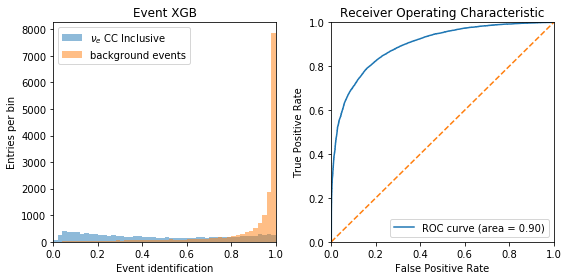

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_event.predict_proba(X_test).T[1]
fpr, tpr, _ = roc_curve(y_test["nueccinc"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["nueccinc"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"$\nu_e$ CC Inclusive",
    density=False,
)
ax[0].hist(
    y_pred[y_test["nueccinc"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="background events",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Event identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Event XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "event_bdt_test.pdf")

In [38]:
%time
# add the columns for each daughter (all samples)
for k, v in sample_info.items():
    v["daughters"]["score_event"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score_event"] = model_event.predict_proba(
        v["daughters"][col_train_event][mask_e_cand]
    ).T[1]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


<IPython.core.display.Javascript object>

In [39]:
query_select = "e_candidate & preselect & score_event>0.9892"
# Passing rate selection
for k, v in sample_info.items():
    # print(
    #    k,
    #    "Duplacate selected events:",
    #    sum(
    #        v["daughters"].query(query_select).groupby(by=["evt", "sub", "run"]).size()
    #        > 1
    #    ),
    # )
    v["daughters"]["select"] = v["daughters"].eval(query_select)
    v["daughters"]["select"] = v["daughters"]["select"].groupby("event").transform(max)

    pass_rate = sum(v["daughters"].eval("(e_candidate & select)")) / v["numentries"]
    print(k, "\t{:.4f}%".format(pass_rate * 100))

# Passing rate signal, weights applied!
pass_rate = sum(
    sample_info["nue"]["daughters"].eval("(e_candidate & select)*weightSpline*nueccinc")
) / sum(sample_info["nue"]["mc"]["weightSpline"] * sample_info["nue"]["mc"]["nueccinc"])
print("nue signal passing the selection \t{:.2f}%".format(pass_rate * 100))
nue_pass = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    * pot_scale
)
print(
    "nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(
        nue_pass, pot_target
    )
)
lee_pass = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*leeweight*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    * pot_scale
)
print("nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass, pot_target))

## Calculate the purity:
purity_denom = (
    sum(sample_info["nu"]["daughters"].eval("(e_candidate & select)*weightSpline"))
    * sample_info["nu"]["scaling"]
)
purity_denom += (
    sum(sample_info["dirt"]["daughters"].eval("(e_candidate & select)*weightSpline"))
    * sample_info["dirt"]["scaling"]
)
purity_denom += (
    sum(sample_info["off"]["daughters"].eval("(e_candidate & select)"))
    * sample_info["off"]["scaling"]
)

purity_mc = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    / purity_denom
)
purity_data = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    / sum(sample_info["on"]["daughters"].eval("(e_candidate & select)"))
)
print(
    "Purity MC: {:.1f}%\nData/MC-ratio: {:.2f}\n".format(
        purity_mc * 100,
        sum(sample_info["on"]["daughters"].eval("(e_candidate & select)"))
        / purity_denom,
    )
)

on 	0.0140%
off 	0.0054%
dirt 	0.0011%
train 	2.4565%
nu 	0.0741%
nue 	15.7641%
nue signal passing the selection 	18.33%
nue Intrinsic signal passing: 26.575 per 1e+20 POT
nue LEE signal passing: 1.628 per 1e+20 POT
Purity MC: 35.2%
Data/MC-ratio: 0.71



<IPython.core.display.Javascript object>

In [40]:
np.savetxt(
    output_dir + "events_run{}.txt".format(run),
    sample_info["on"]["daughters"].query("(e_candidate & select)")[
        ["run", "sub", "evt"]
    ],
    fmt="%u",
)
sample_info["on"]["daughters"].query("(e_candidate & select)")

,,run,sub,evt,topological_score,n_pfps,n_showers,n_tracks,reco_nu_vtx_sce_x,reco_nu_vtx_sce_y,reco_nu_vtx_sce_z,reco_nu_vtx_x,reco_nu_vtx_y,reco_nu_vtx_z,crtveto,crthitpe,slclustfrac,hits_ratio,nu_flashmatch_score,selected,category,nslice,CosmicIP,n_tracks_contained,contained_sps_ratio,contained_fraction,slpdg,trk_score_v,trk_distance_v,trk_theta_v,trk_phi_v,trk_len_v,trk_pid_chipr_v,trk_pid_chimu_v,trk_pid_chipr_v_v,trk_pid_chimu_v_v,trk_pid_chipr_u_v,trk_pid_chimu_u_v,trk_llr_pid_u_v,trk_llr_pid_v_v,trk_llr_pid_y_v,trk_llr_pid_v,trk_llr_pid_score_v,trk_mcs_muon_mom_v,trk_calo_energy_y_v,trk_sce_end_x_v,trk_sce_end_y_v,trk_sce_end_z_v,shr_dist_v,shr_energy_y_v,shr_openangle_v,shr_tkfit_start_x_v,shr_tkfit_start_y_v,shr_tkfit_start_z_v,shr_tkfit_theta_v,shr_tkfit_phi_v,shr_tkfit_dedx_u_v,shr_tkfit_dedx_v_v,shr_tkfit_dedx_y_v,shr_tkfit_gap10_dedx_y_v,shr_tkfit_nhits_v,shr_tkfit_dedx_nhits_u_v,shr_tkfit_dedx_nhits_v_v,shr_tkfit_dedx_nhits_y_v,shr_moliere_avg_v,pfnplanehits_U,pfnplanehits_V,pfnplanehits_Y,pfnhits,pfp_generation_v,pfp_trk_daughters_v,pfp_shr_daughters_v,trk_min_cos,reco_fid_vol,n_pfpvtx,n_pfp_farvtx,e_candidate,shr_tkfit_dedx_wm_v,trk_pid_chimu_wm_v,trk_pid_chipr_wm_v,hits_per_tklen,shr_tkfit_ratiogap_dedx_y_v,trk_muon_hypothesis_ratio_v,_closestNuCosmicDist,preselect,score,score_other_max,score_other_mean,score_other_min,score_event,select
event,daughter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
825,0,5215,52,2625,0.137004,1,1,0,59.290283,-2.205328,516.462219,61.508224,-2.236862,516.428101,0,0.0,0.954248,1.000000,49.772915,1,0,1,68.137260,0,1.0,1.000000,12,0.186336,0.070189,1.378886,-2.023388,83.635689,300.000000,19.564291,130.727875,18.814463,138.756500,23.055485,-11.852999,8.100006e+00,inf,inf,2.467401,0.303701,794.110535,30.096415,-68.854378,522.926880,0.114548,219.550491,-5.721224e+33,61.633087,-2.095165,516.309021,1.362390,-2.035868,2.253522,2.212945,2.674243,3.0,246,11,9,3,3.681170,191,144,103,438,2,0,0,1.000000,True,1.0,0.0,True,2.292521,20.840188,174.034944,5.236999,0.891414,0.000382,999,True,0.991481,1.000000,0.950000,0.900000,0.991445,True
1276,0,5513,27,1390,0.000009,4,2,2,22.688976,50.641026,459.300568,23.350620,50.585922,459.270569,0,0.0,0.851703,1.000000,10.884581,0,0,1,45.593578,0,0.0,0.646203,12,0.002884,0.688593,0.977370,-0.685758,142.701553,198.305695,25.637999,300.000000,33.361340,268.969330,23.116493,552.893066,4.099334e+02,inf,inf,2.467401,0.433336,22976.683594,118.097725,-7.566438,513.392212,0.653228,2134.533447,-1.660853e+23,26.999985,49.214622,463.162140,0.988559,-0.516668,111.303795,0.902320,1.351988,6.0,97,7,2,7,1.739805,1048,800,1101,2949,2,0,0,-0.977476,True,2.0,2.0,True,49.399695,26.837095,251.005231,20.665507,0.225331,0.000019,999,True,0.996541,0.710273,0.422092,0.045765,0.998136,True
2276,0,5235,9,496,0.474377,1,1,0,171.654221,56.406677,126.875603,173.312286,53.156796,127.941681,0,0.0,0.929742,1.000000,4.611319,1,0,1,82.738564,0,1.0,1.000000,12,0.020570,2.783276,1.251061,0.303402,93.159584,265.598694,26.255323,178.966858,27.894951,300.000000,34.373100,201.490158,3.402823e+38,inf,inf,2.467401,0.324926,1437.511475,239.970245,105.862717,165.707916,2.062347,944.649780,2.111948e-28,169.807816,52.473557,122.393227,0.598917,0.229235,0.000000,1.364174,3.709049,10.0,97,0,3,9,6.520017,272,765,551,1588,2,0,0,1.000000,True,1.0,0.0,True,3.122830,28.435645,229.757259,17.046019,0.370905,0.000226,999,True,0.982645,1.000000,0.950000,0.900000,0.993160,True
4329,0,5511,53,2668,0.100078,1,1,0,54.730080,32.871658,318.118652,56.595291,33.208836,318.137177,0,0.0,0.607937,1.000000,17.617283,1,0,1,27.871264,0,1.0,1.000000,12,0.029993,0.369784,1.952928,-1.198796,97.101112,175.580017,26.557034,167.193649,18.956255,300.000000,13.642705,29.034996,6.540205e+01,inf,inf,2.467401,0.333653,130.499313,88.265762,-50.399883,283.049042,0.163386,149.843079,-1.200877e+27,56.401730,33.582489,318.313507,1.951354,-1.184459,3.602922,4.432382,3.108427,4.0,112,7,9,4,3.654853,113,1

<IPython.core.display.Javascript object>

In [41]:
%%time
pickle.dump(sample_info, open(input_dir+"samples.pckl", "wb"))

CPU times: user 3.01 s, sys: 1.39 s, total: 4.4 s
Wall time: 7.41 s


<IPython.core.display.Javascript object>

### Plots

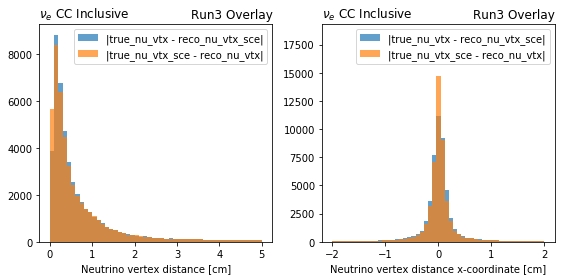

<IPython.core.display.Javascript object>

In [42]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")["true_vtx_distance"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[0].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")["true_vtx_distance_check"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[0].set_xlabel("Neutrino vertex distance [cm]")
ax[0].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[0].set_title("Run3 Overlay", loc="right")
ax[0].legend()

ax[1].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_x+@x_sce_magic-reco_nu_vtx_sce_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[1].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_sce_x-reco_nu_vtx_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[1].set_xlabel("Neutrino vertex distance x-coordinate [cm]")
ax[1].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[1].set_title("Run3 Overlay", loc="right")
ax[1].set_ylim(0, ax[1].get_ylim()[1] * 1.25)
ax[1].legend()

fig.tight_layout()
fig.savefig(output_dir + "vtx_distance.pdf")

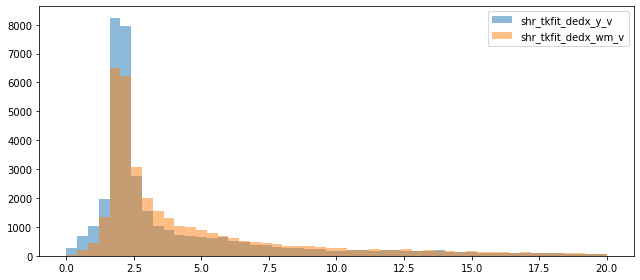

<IPython.core.display.Javascript object>

In [43]:
fig, ax = plt.subplots(ncols=1, figsize=(9, 4))

data = sample_info["nue"]["daughters"].query("e_candidate & abs(backtracked_pdg==11)")[
    ["shr_tkfit_dedx_y_v", "shr_tkfit_dedx_wm_v"]
]

for col in data.columns:
    ax.hist(data[col], bins=50, range=(0, 20), label=col, alpha=0.5)
ax.legend()

fig.tight_layout()
fig.savefig(output_dir + "e_preselection_dedx.pdf")